# Geometría Molecular

En esta sección investigaremos la optimización cuántica de la geometría
molecular de la molécula de hidrógeno $(H_2)$ utilizando dos enfoques
distintos:
1. El Eigensolver Cuántico Variacional (VQE) y
2. La formulación Ising-QUBO con quantum annealing. Estos métodos ofrecen diferentes vías
para abordar el problema de la optimización de la geometría molecular,
cada una con sus propios puntos fuertes y desafíos.

### Enfoque del Eigensolver Cuántico Variacional (VQE)

El Eigensolver Cuántico Variacional (VQE) es un algoritmo híbrido
cuántico-clásico desarrollado para aproximar la energía del estado
fundamental de los sistemas cuánticos. Combina los puntos fuertes de la
computación cuántica y clásica para abordar problemas de química
cuántica y ciencia de materiales. Esta sección desarrolla el enfoque
VQE, cubriendo la definición del sistema molecular, la construcción del
Hamiltoniano, la selección del *ansatz*[^1], la optimización de
parámetros y los criterios de convergencia.

Para abordar este problema, utilizaremos el Hamiltoninano que
caracteriza el sistema, ya que este nos proporcionará la energía de un
cierto estado definido por el *ansatz*. Este proceso de optimización de
la geometría del sistema se puede resumir en:

-   Definición del Hamiltoninao $H(x)$ del sistema.

-   Diseño del circuito variacional para generar los distintos estados
    electrónicos $\ket{\psi(\theta)}$.

-   Definimos le valor esperado del Hamiltoniano sobre un estado
    $f(x,\theta) = \bra{\psi(\theta)}H(x)\ket{\psi(\theta)}$ como la
    función de coste de nuestro problema.

-   Inicializamos los valores de $x$ y $\theta$ para optimizar ambos
    conjuntos de parámetros de tal forma que no solo optimicemos la
    función de coste definida, si no también su gradiente con respecto a
    las coordenadas atómicas
    $\nabla_x f(x,\theta) = \bra{\psi(\theta)}\nabla_x H(x)\ket{\psi(\theta)}$,
    de tal forma que encontremos el punto de equilibro que buscamos.

**Definición del Sistema Molecular**

La molécula de hidrógeno $(H_2)$ es la molécula diatómica más simple y
sirve como caso de prueba fundamental para los algoritmos cuánticos.
Está formada por dos átomos de hidrógeno unidos por un enlace covalente.
El sistema molecular puede describirse mediante dos atributos
fundamentales: la longitud del enlace y la configuración electrónica. En
las simulaciones cuánticas, la longitud del enlace suele variar para
encontrar la geometría de equilibrio en la que se minimiza la energía
del sistema.

Para comprender la molécula de $H_2$ es necesario resolver la ecuación
de Schrödinger para dos electrones que interactúan con los núcleos. La
aproximación de Born-Oppenheimer[^2] simplifica esto desacoplando el
movimiento nuclear y electrónico, permitiendo que el Hamiltoniano se
centre en las interacciones electrónicas [@Szabo1996].

**Construcción del Hamiltoniano Molecular**

Como ya hemos visto en secciones anteriores, el Hamiltoniano del sistema
definido en las bases de Jordan-Wigner, se puede expresar en función de
los distintos operadores de Pauli, de forma que sea sencillamente
implementable en un computador cuántico.

En Pennylane, el Hamiltoniano para $H_2$ se puede construir utilizando
el módulo 'qchem', que traduce automáticamente el Hamiltoniano molecular
al Hamiltoniano de spin que necesitamos:

In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.0 MB/s eta 0:00:00


In [19]:
import pennylane as qml
from pennylane import numpy as np
# Definimos los símbolos para la molécula de Hydrógeno
symbols = ["H", "H"]

# Establecemos las coordenadas para los dos átomos de hidrógeno (x, y, z) en angstroms
x = np.array([0.0, 0.0, 0.0,  # Coordenadas primer átomo de H
              0.74, 0.0, 0.0],  # Coordenadas segundo átomo de H (separación ~0.74 Å)
              requires_grad=True)

# Definimos la función para crear el Hamiltoniano para la molécula de hidrógeno
def H(x):
    molecule = qml.qchem.Molecule(symbols, x, charge=0)
    return qml.qchem.molecular_hamiltonian(molecule)[0]
# Imprimimos el Hamiltoniano Molecular H(x)
print(str(H(x)).split('+')[0], *['+' + item for item in str(H(x)).split('+')[1:]], sep='\n')

0.7784107516237712 * I(0) 
+ 0.23718740030498486 * Z(0) 
+ 0.2371874003049847 * Z(1) 
+ 0.18456105296876102 * (Z(0) @ Z(1)) 
+ -0.46124957076322465 * Z(2) 
+ 0.14065700585010005 * (Z(0) @ Z(2)) 
+ 0.18170118517545303 * (Z(1) @ Z(2)) 
+ 0.04104417932535298 * (Y(0) @ X(1) @ X(2) @ Y(3)) 
+ -0.04104417932535298 * (Y(0) @ Y(1) @ X(2) @ X(3)) 
+ -0.04104417932535298 * (X(0) @ X(1) @ Y(2) @ Y(3)) 
+ 0.04104417932535298 * (X(0) @ Y(1) @ Y(2) @ X(3)) 
+ -0.4612495707632247 * Z(3) 
+ 0.18170118517545303 * (Z(0) @ Z(3)) 
+ 0.14065700585010005 * (Z(1) @ Z(3)) 
+ 0.1917875056241929 * (Z(2) @ Z(3))


**Selección del Ansatz**

Aquí describimos el segundo paso del algoritmo cuántico: definir el
circuito cuántico para preparar el estado electrónico básico
$|\psi(\theta)\rangle$ de la molécula de hidrógeno $(H_2)$.

En este caso, se necesitan cuatro qubits para codificar el número de
ocupación de los orbitales de espín moleculares. Para capturar los
efectos de las correlaciones electrónicas, necesitamos preparar el
sistema de 4 qubits en una superposición del estado Hartree-Fock
$|1100\rangle$ con otros estados que difieren por una doble o única
excitación. Por ejemplo, el estado $|0011\rangle$ se obtiene excitando
dos partículas de los qubits 0, 1 a 2, 3. Del mismo modo, el estado
$|1010\rangle$ corresponde a una única excitación desde el qubit 1 al 2.
Esto puede lograrse utilizando las puertas de excitación única y doble
$G$ y $G^{(2)}$, implementadas en forma de rotaciones Givens [^3] en
PennyLane.

Además, utilizamos un algoritmo adaptativo para seleccionar las
operaciones de excitación incluidas en el circuito cuántico variacional.
El algoritmo procede como sigue:

1.  **Generar los índices de los qubits envueltos en simple y doble
    exitación.** Por ejemplo, los índices del estado de excitación
    simple $|1010\rangle$ vienen dados por la lista $[1, 2]$. Del mismo
    modo, los índices del estado doblemente excitado $|0011\rangle$ son
    $[0, 1, 2, 3]$.

2.  **Construir el circuito utilizando todas las puertas de doble
    excitación.** Calcular el gradiente de la función de coste
    $g(\theta,x)$ con respecto a cada puerta de doble excitación y
    retener sólo aquellas con gradiente distinto de cero.

3.  **Incluir las puertas de doble excitación seleccionadas y repetir el
    proceso para las puertas de simple excitación.**

4.  **Construir el circuito cuántico variacional final incluyendo las
    puertas seleccionadas.**

Para la molécula de hidrógeno $(H_2)$ en un conjunto de bases mínimo,
tenemos un total de cuatro excitaciones del estado de referencia. Tras
aplicar el algoritmo adaptativo, el circuito cuántico final contiene una
única operación de doble excitación que actúa sobre los qubits
$[0, 1, 2, 3]$. El circuito se ilustra en la figura
[\[fig:ansatz_geom\]](#fig:ansatz_geom){reference-type="ref"
reference="fig:ansatz_geom"}.

Para implementar este circuito cuántico, utilizamos la función
**hf_state()** para generar el vector de números de ocupación que
representa el estado Hartree-Fock [^4].

In [12]:
# Definimos el número de electrones y orbitales
# para la molécula de H_2
electrons = 2  # H_2 tiene 2 electrones
orbitals = 4  # H_2 ocupará 2 orbitales moleculares (1 para cada átomo de hidrógeno)

# Generamos el estado Hartree-Fock para la molécula de H_2
hf = qml.qchem.hf_state(electrons=electrons, orbitals=orbitals)
print(hf)

[1 1 0 0]


La matriz **hf** es utilizada por la operación **BasisState** para
inicializar el registro de qubits. A continuación, se aplican primero
las operaciones **DoubleExcitation**, definimos el dispositivo cuántico
utilizado para calcular el valor esperado. En este ejemplo, utilizamos
el simulador **lightning.qubit**:

In [20]:
# Definimos el númeo de qubits (wires) necesarios para la molécula H_2
num_wires = 4  # 2 orbitales requiren 4 qubits (2 qubits por orbital)
# Definimos el dispositivo cuántico utilizado para calcular el valor esperado
dev = qml.device("lightning.qubit", wires=num_wires)

# Definimos el circuito cuántico para preparar el estado básico electrónico de la molécula H_2
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # Initializamos el circuito con el estado Hartree-Fock
    qml.BasisState(hf, wires=wires)

    # Aplicamos una excitación simple para H_2 (solo una doble excitación es necesaria)
    qml.DoubleExcitation(params[0], wires=[0, 1, 2, 3])

    return qml.expval(obs)

Este circuito prepara el estado de prueba (*ansatz*). Si sólo se utiliza
una excitación doble para la molécula de hidrógeno $(H_2)$, la fórmula
se simplifica ya que no es necesario considerar las excitaciones
simples. El estado cuántico variacional $|\psi(\theta)\rangle$ sería:

$$|\psi(\theta)\rangle = \cos(\theta)|1100\rangle - \sin(\theta)|0011\rangle$$

En esta expresión:

-   $|1100\rangle$ es el estado de referencia Hartree-Fock.

-   $|0011\rangle$ representa la doble excitación donde dos electrones
    son excitados desde los dos primeros qubits (0 y 1) a los dos
    últimos qubits (2 y 3).

El parámetro $\theta$ controla la superposición entre el estado de
referencia y el estado de doble excitación, teniendo en cuenta las
correlaciones electrónicas dentro de la molécula de hidrógeno.

**Definir la función de coste $g(\theta,x)$.**

Este paso consiste en definir la función de coste

$$g(\theta,x)=\langle\psi(\theta)|H(x)|\psi(\theta)\rangle$$

Evalúa el valor esperado del Hamiltoniano parametrizado $H(x)$ en el
estado de prueba $|\psi(\theta)\rangle$.

A continuación, definimos la función de coste $g(\theta,x)$ que depende
tanto del circuito como de los parámetros del Hamiltoniano. En concreto,
consideramos los valores esperados del Hamiltoniano.

In [21]:
# Definimos el la función de coste
def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires))

La función de coste es minimizada al calcular los gradientes con
respecto tanto a los parámetros del circuito $\theta$ (calculo analítico
con técnicas de diferenciación automática de PennyLane) como a las
coordenadas nucleares $x$ (tomando el valor esperado del Hamiltoniano
electrónico).

Utilizamos la función **finite_diff()** para calcular el gradiente del
Hamiltoniano utilizando una aproximación por diferencia central. A
continuación, evaluamos el valor esperado de los componentes del
gradiente $\dfrac{\partial H(x)}{\partial x_i}$. Esto se implementa
mediante la función **grad_x()**:

In [22]:
#Definimos la función finite_diff()
def finite_diff(f, x, delta=0.01):
    # Calcular la diferencia finita por diferencia central
    # de una función.
    gradient = []

    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1
        gradient.append(res)

    return gradient

# Definimos la función grad_x()
def grad_x(params, x):
    # Calcular el gradiente del valor esperado con respecto
    # a las coordenadas nucleares x.
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires))
            for obs in grad_h]
    return np.array(grad)

**Optimización de la Geometría Molecular**

Ahora procedemos a minimizar la función de coste para encontrar la
geometría de equilibrio del estado fundamental de la molécula $H_2$.

Comenzamos definiendo los optimizadores clásicos, inicializamos los
parámetros del circuito $\theta$. El ángulos $\theta$ se ponen a cero
para que el estado inicial $|\psi(\theta)\rangle$ sea el estado
Hartree-Fock.

El conjunto inicial de coordenadas nucleares x, definido al principio,
se basa en que la distancia de 0.74  es una longitud de enlace típica
para la molécula de $H_2$. Esta es una elección natural para la
geometría de partida que pretendemos mejorar debido a los efectos de
correlación electrónica incluidos en el estado de prueba
$|\psi(\theta)\rangle$.

Realizamos la optimización sobre un máximo de 100 pasos. Los parámetros
del circuito y las coordenadas nucleares se optimizan hasta que el
componente máximo del gradiente nuclear $\nabla_x g(\theta, x)$ es menor
o igual a $10^{-5}$ Hartree/Bohr [^5]. Normalmente, este es el criterio
de convergencia utilizado para optimizar geometrías moleculares en
simulaciones de química cuántica.

In [102]:
import matplotlib.pyplot as plt
# Inicialización
# Parámetro inicial para la puerta de excitación
theta = np.array([0.0], requires_grad=True)
# Coordenadas iniciales del primer y segundo átomo de H
x = np.array([0.0, 0.0, 0.0,
              0.74, 0.0, 0.0], requires_grad=True)

# Definimos optimizadores clásicos para los parámetros
# y para las coordenadas nucleares
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)

# Almacenamos los valores la función de coste y
# de la longitud de enlace
energy = []
bond_length = []

# Factor para convertir de Bohrs a Angstroms
bohr_angs = 0.529177210903

# Definimos el Bucle de Optimización
for n in range(100):

    # Optimizamos los parámetros del circuito
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimizamos las coordenadas nucleares
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    # Almacenamos los valores de energía y longitud de enlace
    energy.append(cost(theta, x))
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)

    # Obtenemos progreso de resultados cada 4 pasos
    if n % 4 == 0:
        print(f"Paso = {n},  E = {energy[-1]:.8f} Ha,longitud  de enlace = {bond_length[-1]:.5f} A")

    # Comprobamos el componente máximo del gradiente nuclear
    if np.max(grad_x(theta, x)) <= 1e-05:
        break

# Obtenemos el resultado final
print("\n" f"Valor final de la energía del estado fundamental = {energy[-1]:.8f} Ha")
print("\n" "Geometría de equilibrio del estado fundamental")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
symbols = ["H", "H"]
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}  {x[3 * i + 2]:.4f}")

Paso = 0,  E = -0.96759639 Ha,longitud  de enlace = 1.36072 A
Paso = 4,  E = -1.12497203 Ha,longitud  de enlace = 0.87252 A
Paso = 8,  E = -1.13708572 Ha,longitud  de enlace = 0.74090 A
Paso = 12,  E = -1.13729276 Ha,longitud  de enlace = 0.73607 A
Paso = 16,  E = -1.13730528 Ha,longitud  de enlace = 0.73516 A

Valor final de la energía del estado fundamental = -1.13730596 Ha

Geometría de equilibrio del estado fundamental
symbol    x        y        z
  H    -0.3244   0.0000  0.0000
  H    1.0644   0.0000  0.0000


A continuación se muestran los resultados obtenidos por el proceso de
Optimización.

![Resultados Proceso de Optimización Geometría Molecular
$H_2$.](H2_geometria02.png){#fig:h2_geom_opt width="0.75\\linewidth"}

**Convergencia y terminación**

La convergencia se evalúa monitorizando el cambio en los valores de
energía durante la optimización. Los criterios de convergencia suelen
incluir:

-   **Umbral de cambio de energía:** El proceso de optimización se
    considera convergente si el cambio de energía entre iteraciones cae
    por debajo de un umbral predefinido.

-   **Número de iteraciones:** A menudo se fija un número máximo de
    iteraciones para evitar un cálculo excesivo.

Analizar la convergencia implica trazar los valores de energía a lo
largo de las iteraciones y examinar si el algoritmo alcanza una solución
estable [@Farhi2014][@Cerezo2021].

A continuación, trazamos los valores de la energía de estado fundamental
de la molécula y la longitud de enlace en función del paso de
optimización.

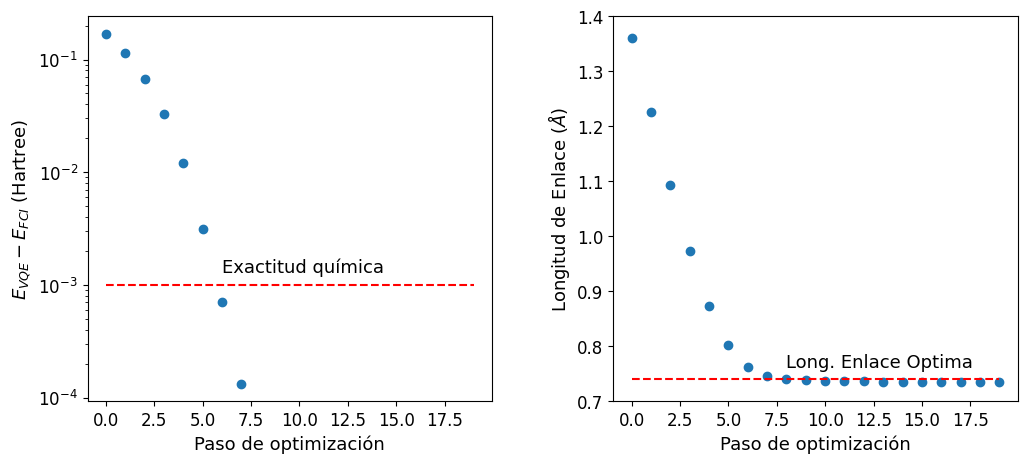

In [99]:
import matplotlib.pyplot as plt

# Valores finales de energía y longitud de enlace para H_2 (debe sustituise por los valores de referencia)
E_fci = -1.137  # Energía final de FCI para H_2 (Hartree)
d_fci = 0.741  # Longitud de enlace de equilibrio para H2 (A)

# Creamos la gráfica
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Agregamos la gráfica de energía a la primera columna
E_vqe = np.array(energy)  # Valores de Energía en optimización VQE
ax1 = fig.add_subplot(121)

# Trazamos la diferencia de energía
ax1.plot( E_vqe - E_fci, "o")
# Línea de exactitud química
ax1.plot( np.full(len(E_vqe), 0.001), color="red",ls="dashed")
#ax1.set_ylim([-0.00004, 0.17])
ax1.set_xlabel("Paso de optimización", fontsize=13)
ax1.set_ylabel("$E_{VQE} - E_{FCI}$ (Hartree)", fontsize=13)
ax1.text(6, 0.0013, r"Exactitud química", fontsize=13)
plt.yscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Agregamos gráfica de longitud de enlace a la segunda columna
ax2 = fig.add_subplot(122)
# gráfica de longitud de enlace
ax2.plot(range(len(bond_length)), bond_length, "o", label='Longitud de Enlace')
# Línea de longitud de enlace de equilibrio
ax2.plot(range(len(bond_length)), np.full(len(bond_length), d_fci), color="red",ls="dashed")
ax2.set_ylim([0.7, 1.4])  # Límites_y para la longitud de enlace
ax2.set_xlabel("Paso de optimización", fontsize=13)
ax2.set_ylabel("Longitud de Enlace ($\AA$)", fontsize=13)
ax2.text(8, d_fci + 0.02, r"Long. Enlace Optima ", fontsize=13, ha='left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3)
plt.show()

A continuación, se muestra la gráfica obtenida de los valores de la
energía de estado fundamental de la molécula en función del paso de
optimización.

![Energía en función del paso de
optimización.](H2_geometria03.png){#fig:h2_geom_energ
width="0.5\\linewidth"}

Ahora se muestra la gráfica de los valores de la longitud de enlace en
función del paso de optimización.

![Longitud de Enlace en función del paso de
optimización.](H2_geometria04.png){#fig:h2_geom_bondl
width="0.5\\linewidth"}

### Enfoque del marco Ising-QUBO

Como hemos visto en secciones anteriores el modelo Ising es un modelo
clásico de mecánica estadística en el que el estado del sistema se
describe mediante variables binarias (espines) que interactúan según un
Hamiltoniano. También vimos que la formulación QUBO representa los
problemas de optimización como una función cuadrática de variables
binarias. Ambos modelos pueden mapearse en recocidos cuánticos o
simularse utilizando algoritmos cuánticos para encontrar soluciones
óptimas [@Lucas2014][@DWave2023].

El marco Ising-QUBO es una potente herramienta para la resolución de
problemas de optimización combinatoria mediante su adaptación al modelo
Ising o a problemas de optimización binaria cuadrática sin restricciones
(QUBO). Esta sección detalla la aplicación del enfoque Ising-QUBO para
optimizar la geometría molecular de la molécula de hidrógeno $(H_2)$,
utilizando las bibliotecas OpenFermion/PySCF y Dwave para su implementación.

1.  **Paso 1: Definición del Hamiltoniano Molecular**

    El primer paso en la implementación del enfoque Ising-QUBO es
    definir el Hamiltoniano molecular para $H_2$. Este Hamiltoniano
    representa la energía total del sistema, incluyendo la energía
    cinética de los electrones, la energía potencial debida a la
    repulsión electrón-electrón, y la atracción electrón-nuclear.

    Matemáticamente, el Hamiltoniano para una molécula en la segunda
    forma cuantizada se expresa como:

    $$H_{\text{molecular}} = \sum_{pq} h_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} g_{pqrs} a_p^\dagger a_q^\dagger a_r a_s$$

    donde $h_{pq}$ y $g_{pqrs}$ son integrales de uno y dos electrones,
    respectivamente, y $a_p^\dagger$, $a_q$ son operadores fermiónicos
    de creación y aniquilación [@Szabo1996].

    Usando las librerías OpenFermiun y PySCF, ampliamente utilizadas en el campo de la qiímica computacional, definimos la molécula de Hidrógeno y obtenemos el  .


In [107]:
!pip install openfermionpyscf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.8 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13820 sha256=c6d4da10977779c5ba7fe7bd2c9c5530a878c4eb3f57eae30490766b004772ff
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [109]:
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator, jordan_wigner
from pyscf import gto, scf

# Definir la geometr?a de la mol?cula de H2
geometry = [('H', (0, 0, 0)), ('H', (0, 0, 0.7414))]

# Definir la mol?cula en PySCF
mol = gto.Mole()
mol.build(
    atom='H 0 0 0; H 0 0 0.7414',
    basis='sto-3g',
    unit='angstrom'
)

# Calcular el Hartree-Fock con PySCF
mf = scf.RHF(mol)
mf.kernel()

# Almacenar los datos moleculares en un objeto MolecularData de OpenFermion
molecular_data = MolecularData(
    geometry=geometry,
    basis='sto-3g',
    multiplicity=1,
    charge=0
)

# Ejecutar PySCF con OpenFermion para obtener los integrales
molecular_data = run_pyscf(molecular_data, run_scf=True, run_fci=True)

# Obtener el Hamiltoniano molecular en formato de fermiones
hamiltonian = molecular_data.get_molecular_hamiltonian()
print(hamiltonian)

converged SCF energy = -1.11668438708534
() 0.7137539936876182
((0, 1), (0, 0)) -1.2524635735648983
((1, 1), (1, 0)) -1.2524635735648983
((2, 1), (2, 0)) -0.4759487152209643
((3, 1), (3, 0)) -0.4759487152209643
((0, 1), (0, 1), (0, 0), (0, 0)) 0.3372443831784189
((0, 1), (0, 1), (2, 0), (2, 0)) 0.09064440410574799
((0, 1), (1, 1), (1, 0), (0, 0)) 0.3372443831784189
((0, 1), (1, 1), (3, 0), (2, 0)) 0.09064440410574799
((0, 1), (2, 1), (0, 0), (2, 0)) 0.09064440410574799
((0, 1), (2, 1), (2, 0), (0, 0)) 0.3317340482117839
((0, 1), (3, 1), (1, 0), (2, 0)) 0.09064440410574799
((0, 1), (3, 1), (3, 0), (0, 0)) 0.3317340482117839
((1, 1), (0, 1), (0, 0), (1, 0)) 0.3372443831784189
((1, 1), (0, 1), (2, 0), (3, 0)) 0.09064440410574799
((1, 1), (1, 1), (1, 0), (1, 0)) 0.3372443831784189
((1, 1), (1, 1), (3, 0), (3, 0)) 0.09064440410574799
((1, 1), (2, 1), (0, 0), (3, 0)) 0.09064440410574799
((1, 1), (2, 1), (2, 0), (1, 0)) 0.3317340482117839
((1, 1), (3, 1), (1, 0), (3, 0)) 0.09064440410574799
(

Se construye el Hamiltoniano molecular $H_{\text{molecular}}$, que sirve como punto de partida para el mapeo al modelo de Ising.

2.  **Paso 2: Mapeo Qubit y Representación del Modelo Ising**

    Para aplicar técnicas de computación cuántica, el Hamiltoniano
    molecular debe transformarse de operadores fermiónicos a operadores
    qubit. Esta transformación se realiza normalmente utilizando métodos
    como las transformaciones Jordan-Wigner o Bravyi-Kitaev
    [@Jordan1928]. Estas transformaciones convierten el hamiltoniano
    fermiónico en un hamiltoniano qubit, que es una suma de matrices de
    Pauli.

    El Hamiltoniano qubit puede escribirse como:

    $$H_{\text{qubit}} = \sum_{i} c_i P_i$$

    donde $P_i$ son productos tensoriales de matrices Pauli, y $c_i$ son
    coeficientes derivados de las integrales en el Hamiltoniano
    molecular.

    En el contexto del modelo de Ising, el Hamiltoniano puede interpretarse como una función de energía donde los operadores Pauli-Z corresponden a variables de espín $s_i = \pm 1$. El Hamiltoniano de Ising se representa como

    $$H_{\text{Ising}} = -\sum_{i,j} J_{ij} s_i s_j - \sum_i h_i s_i$$

    Aquí, los coeficientes $J_{ij}$ y $h_i$ corresponden a los términos de interacción y campos externos en el modelo de Ising, que se relacionan con los coeficientes $c_i$ en el Hamiltoniano del qubit[@Lucas2014].

    OpenFermion maneja automáticamente esta transformación:

In [110]:
# Convertir a qubits usando la transformación de Jordan-Wigner
qubit_hamiltonian = jordan_wigner(get_fermion_operator(hamiltonian))

# Imprimir el Hamiltoniano en qubits
print(qubit_hamiltonian)

(-0.09886396933545849+0j) [] +
(-0.045322202052874+0j) [X0 X1 Y2 Y3] +
(0.045322202052874+0j) [X0 Y1 Y2 X3] +
(0.045322202052874+0j) [Y0 X1 X2 Y3] +
(-0.045322202052874+0j) [Y0 Y1 X2 X3] +
(0.17119774903432977+0j) [Z0] +
(0.16862219158920946+0j) [Z0 Z1] +
(0.12054482205301802+0j) [Z0 Z2] +
(0.165867024105892+0j) [Z0 Z3] +
(0.17119774903432974+0j) [Z1] +
(0.165867024105892+0j) [Z1 Z2] +
(0.12054482205301802+0j) [Z1 Z3] +
(-0.22278593040418457+0j) [Z2] +
(0.17434844185575676+0j) [Z2 Z3] +
(-0.2227859304041846+0j) [Z3]


3.  **Paso 3: Mapeo a QUBO**
Una vez que el Hamiltoniano molecular se expresa como un Hamiltoniano qubit, el siguiente paso es convertirlo en una formulación QUBO. El modelo QUBO representa el problema en términos de variables binarias $x_i \in \{0, 1\}$. El problema QUBO viene definido por la función de energía:

    $$Q(x) = \sum_{i} a_i x_i + \sum_{i < j} b_{ij} x_i x_j$$

    donde $a_i$ y $b_{ij}$ son coeficientes que definen los términos lineales y cuadráticos, respectivamente [@McGeoch2014].

    La correlación entre el Hamiltoniano qubit y la formulación QUBO se
    establece mapeando las variables de espín en el modelo de Ising a
    variables binarias:

    $$s_i = 2x_i - 1$$

    Usando este mapeo, el Hamiltoniano de Ising puede reescribirse como
    una matriz QUBO:

    $$Q(x) = (2x - 1)^T J (2x - 1) + h^T (2x - 1)$$

    El siguiente código Python ilustra cómo realizar este mapeo y
    construir la matriz QUBO:

In [111]:
!pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.

In [114]:
# Función para mapear Hamiltoniano_qubit a Hamiltoniano_qubo
import openfermion
import dimod

def qubit_hamiltonian_to_qubo(qubit_hamiltonian):
    qubo = {}
    offset = 0.0

    for term, coeff in qubit_hamiltonian.terms.items():
        #print(coeff.real)
        # Obtener los qubits y operadores de Pauli del término
        qubits = []
        is_qubo = True

        # Iterar sobre los operadores de Pauli y asegurarse de que solo haya términos de Z o identidad
        for qubit, pauli in term:
            #print(qubit, pauli)
            if pauli == 'Z':  # Solo los términos Z pueden mapearse directamente a QUBO
                qubits.append(qubit)
            else:
                is_qubo = False
                break

        if not is_qubo:
            # Saltamos los términos con operadores X o Y, ya que no pueden mapearse directamente a QUBO
            continue

        # Asignar el término al diccionario QUBO
        if len(qubits) == 0:  # Término constante
            offset += coeff.real
        elif len(qubits) == 1:  # Término lineal (un solo qubit)
            qubit = qubits[0]
            qubo[(qubit, qubit)] = qubo.get((qubit, qubit), 0) + coeff.real
        elif len(qubits) == 2:  # Término cuadr?tico (interacción entre dos qubits)
            qubit1, qubit2 = qubits
            qubo[(qubit1, qubit2)] = qubo.get((qubit1, qubit2), 0) + coeff.real

    return qubo, offset

# Convertir a QUBO
qubo, offset = qubit_hamiltonian_to_qubo(qubit_hamiltonian)

print("Diccionario QUBO:")
print(qubo)
print("Offset:", offset)

Diccionario QUBO:
{(0, 0): 0.17119774903432977, (1, 1): 0.17119774903432974, (2, 2): -0.22278593040418457, (3, 3): -0.2227859304041846, (0, 1): 0.16862219158920946, (0, 2): 0.12054482205301802, (0, 3): 0.165867024105892, (1, 2): 0.165867024105892, (1, 3): 0.12054482205301802, (2, 3): 0.17434844185575676}
Offset: -0.09886396933545849


Esta función convierte el Hamiltoniano qubit en una matriz QUBO,
    preparándolo para la optimización utilizando solucionadores
    cuánticos o clásicos.

4.  **Paso 4: Resolver el Problema QUBO**

    El problema QUBO está ahora listo para ser resuelto. La solución
    puede obtenerse utilizando el quantum annealing o algoritmos
    clásicos como el annealing simulado.

    **Annealing clásico** El problema QUBO puede resolverse primero
    utilizando métodos clásicos como el annealing simulado. En este caso,
    utilizamos la biblioteca dimod:

In [115]:
import dimod

# Creamos un BinaryQuadraticModel a partir de la matriz QUBO
bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)

# Utilizamos un solucionador clásico (ej: annealing simulado)
sampler = dimod.SimulatedAnnealingSampler()
solution = sampler.sample(bqm, num_reads=1000)

# Extraemos la mejor solución
best_solution = solution.first.sample
best_energy = solution.first.energy

print(f"Mejor solución: {best_solution}")
print(f"Mejor energía: {best_energy}")


Mejor solución: {0: 0, 1: 0, 2: 1, 3: 1}
Mejor energía: -0.2712234189526124


**Quantum Annealing:** El quantum annealing ofrece un enfoque
    alternativo explotando la tunelización cuántica para encontrar el
    mínimo global del problema QUBO. Esto puede simularse
    utilizando la pila de software Ocean de D-Wave, que proporciona una
    interfaz para quantum annealing:

In [116]:
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite

sampler = EmbeddingComposite(DWaveSampler(token='DEV-b7beb67563703b89fa4bbba9c70342e2fa8ed1b3'))
solution = sampler.sample_qubo(qubo, num_reads=1000)

best_solution = solution.first.sample
best_energy = solution.first.energy

print(f"Mejor solución (quantum): {best_solution}")
print(f"Mejor energía (quantum): {best_energy}")

Mejor solución (quantum): {0: 0, 1: 0, 2: 1, 3: 1}
Mejor energía (quantum): -0.2712234189526124


Quantum annealing is particularly advantageous for large-scale problems where classical methods may struggle with local minima [@Kadowaki1998].

El solucionador devuelve la configuración binaria que minimiza la función objetivo QUBO, correspondiente a la energía del estado fundamental de la molécula de hidrógeno.

5.  **Paso 5: Interpretación y Análisis**

    El último paso consiste en interpretar la solución del problema QUBO
    en términos de la geometría molecular del $H_2$. La solución binaria
    representa la configuración óptima de qubits (o espines) que
    minimiza la función de energía. Esta configuración se correlaciona
    con la estructura electrónica de la molécula de hidrógeno,
    proporcionando información sobre su geometría en estado básico.

    La energía obtenida puede compararse con valores teóricos y
    resultados de otros métodos (como VQE) para evaluar la precisión y
    eficacia de la aproximación Ising-QUBO [@Schuld2018].

    **Correlación con los modelos matemáticos Ising-QUBO**

    Los pasos anteriores se correlacionan directamente con la
    formulación matemática de los modelos Ising y QUBO:

    -   **Definición del Hamiltoniano:** El Hamiltoniano molecular
        representa la energía total del sistema físico, modelado
        matemáticamente como una suma de matrices de Pauli después de la
        transformación.

    -   **Mapeo Qubit:** El mapeo de operadores fermiónicos a qubits
        permite la representación del Hamiltoniano en términos de
        variables de espín, esencial para el modelo de Ising.

    -   **Mapeo de qubits:** La traslación de variables de espín a
        variables binarias tiende un puente entre la mecánica cuántica y
        la optimización combinatoria, permitiendo el uso del recocido
        cuántico para la resolución del problema.

    -   **Optimización:** Resolver el problema QUBO equivale a encontrar
        el estado fundamental del modelo de Ising, correspondiente a la
        configuración de energía mínima del sistema molecular.

    Esta implementación demuestra la aplicación práctica de modelos
    teóricos en química cuántica y optimización, ilustrando cómo
    conceptos matemáticos abstractos pueden traducirse en algoritmos
    computacionales utilizando librerías de software cuántico como
    PennyLane.

6.  **Análisis de resultados**

    -   **Cálculo de la energía y calidad de la solución**

        La solución proporcionada por el quantum annealing o el
        solucionador clásico incluye las configuraciones binarias
        óptimas de las variables. Los valores energéticos
        correspondientes se calculan a partir de la función objetivo
        QUBO. Para la molécula de hidrógeno, estas soluciones deben
        aproximarse a la energía del estado fundamental obtenida a
        partir de otros métodos, como VQE
        [@Montanaro2016][@Preskill2018].

    -   **Convergencia y rendimiento**

        El rendimiento y la convergencia del enfoque QUBO dependen de
        factores como la calidad de la formulación QUBO y las
        capacidades del quantum annealing. La distribución de energía y
        la precisión de la solución pueden analizarse para evaluar la
        eficacia del enfoque [@Korenblit2015][@Choi2022].

    -   **Comparación con otros métodos**

        El marco Ising-QUBO proporciona una valiosa alternativa a
        métodos como VQE aprovechando los puntos fuertes de los
        recocidos cuánticos para problemas de optimización binaria a
        gran escala. Mientras que VQE es más adaptable a varios ansatz y
        métodos de optimización, el enfoque Ising-QUBO sobresale en
        problemas que pueden ser directamente mapeados a problemas de
        optimización binarios [@Choi2022][@Lucas2014].

    -   **Orientaciones futuras**

        La investigación futura en el marco Ising-QUBO podría centrarse
        en mejorar las técnicas de formulación QUBO e integrarlas con
        algoritmos cuánticos avanzados. Además, la exploración de
        enfoques híbridos que combinen el quantum annealing con métodos
        de optimización clásicos podría mejorar el rendimiento y la
        aplicabilidad del enfoque Ising-QUBO [@Arute2019][@Choi2022].

[^1]: Un **ansatz** es una conjetura bien informada sobre la forma de
    una solución a un problema específico. Sirve de plantilla o molde
    para empezar a explorar el espacio de soluciones, en lugar de
    empezar desde cero. El ansatz es esencial para la computación
    cuántica debido a la complejidad de los sistemas cuánticos y a la
    necesidad de algoritmos eficientes.

[^2]: La aproximación Born-Oppenheimer simplifica el cálculo de las
    propiedades moleculares separando el movimiento electrónico del
    nuclear, suponiendo que los núcleos son mucho más pesados y se
    mueven más lentamente que los electrones. Proporciona un marco para
    comprender las vibraciones moleculares, la espectroscopia y las
    superficies de energía potencial. Sin embargo, la aproximación tiene
    limitaciones, como la ruptura en las intersecciones cónicas y los
    efectos no adiabáticos.

[^3]: En álgebra lineal, una rotación Givens es una rotación en el plano
    abarcado por dos coordenadas (digamos, las coordenadas ii-ésima y
    jj-ésima) de un vector. Se utiliza para introducir ceros en matrices
    (por ejemplo, durante la descomposición QR). En PennyLane, las
    rotaciones de Givens se utilizan para implementar operaciones de
    excitación simple y doble en algoritmos cuánticos variacionales,
    como el Eigensolver Cuántico Variacional (VQE). Estas operaciones
    son cruciales para preparar estados cuánticos que representen
    estructuras electrónicas en moléculas.

[^4]: El estado Hartree-Fock es una aproximación utilizada para
    describir la estructura electrónica de átomos y moléculas. Se basa
    en la idea de que los electrones pueden representarse como productos
    de funciones de onda individuales, denominadas orbitales. El método
    Hartree-Fock consiste en minimizar la energía total del sistema
    variando los orbitales. Aunque tiene limitaciones, el estado
    Hartree-Fock es una aproximación útil y un punto de partida para
    métodos más avanzados en química cuántica.

[^5]: Hartree/Bohr es una unidad de fuerza en unidades atómicas, un
    Hartree equivale aproximadamente a 27,211 electronvoltios (eV) y un
    Bohr es aproximadamente igual a 0.52918 Angstroms.